# Model to Predict Proportion of Images with digit 7 in MNIST dataset, based on the paper: Obtaining Spatially Resolved Tumor Purity Maps Using Deep Multiple Instance Learning In A Pan-cancer Study

We shall be using the popular deep learning library , pytorch to implement the model.
Matplotlib is used for visualisation and pandas is used for data manipulation.

Be sure to install the  modules to run the code:

* pip install pandas

* pip install pip3 install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio===0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

* pip install matplotlib

* pip install numpy


### Import Dependencies

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import os
import shutil

import torch.optim
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Subset
from torchvision.models.resnet import resnet18
from torch.nn import Conv2d
import torch.nn as nn
import pandas as pd

### Select the GPU for faster computation

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Download the MNIST Dataset
Pytorch has a readily available MNIST dataset.

We load the dataset and apply the image transformations necessary to make it compatbile with ResNet18 (pytorch implementation)
see: https://pytorch.org/hub/pytorch_vision_resnet/ for details.

In [4]:
#define a transform to convert the image to RGB
class RGBTransform(object):
    """
    A simple class for converting greyscale images to rgb.
    """
    def __init__(self, current="L", transform="RGB"):
        self.transform = transform
        self.current = current

    def __call__(self, img):
        return img.convert(self.transform)


In [5]:

train_valid_data= datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       RGBTransform(),
                       transforms.ToTensor(),
                       transforms.Resize(256),
                        transforms.CenterCrop(224),
                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]))
       
test_data= datasets.MNIST('../data', train=False, download=True,
                   transform=transforms.Compose([
                       RGBTransform(),
                       transforms.ToTensor(),
                       transforms.Resize(256),
                        transforms.CenterCrop(224),
                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape: torch.Size([3, 224, 224])
image shape: torch.Size([3, 224, 224])
image shape: torch.Size([3, 224, 224])
image shape: torch.Size([3, 224, 224])
image shape: torch.Size([3, 224, 224])
image shape: torch.Size([3, 224, 224])


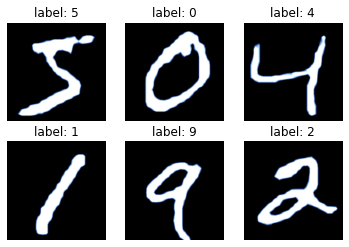

In [6]:
#plot a few instances in the training data
def plot_img(img,axs,i):
    print("image shape:",img.shape)
    #reshape img to (28,28,3) from (3,28,28)
    
    img=img.numpy().transpose((1,2,0))
    axs[i//3,i%3].imshow(img)
    axs[i//3,i%3].axis('off')
    axs[i//3,i%3].set_title('label: {}'.format(train_valid_data[i][1]))

fig, axs= plt.subplots(2,3)

for i in range(0, 6):
  plot_img(train_valid_data[i][0],axs,i)

In [7]:


def produce_bag(dataset, bag_size,indices):
    ''' The produce bag function accepts a pytorch dataset, a bag size and a list of shuffled indices 
    indicating the indices of the images to pick.
    
    It produces a bag containing bag_size images and their corresponding labels. It first filters
    the images that are either labelled 0 or 7, and then aggregates them into bag. The label of the bag is a float, the proportion
    of images in the bag that are labelled as 7.
    
    It does this by selecting the first {n_bags} indices from the indices list, and then popping the indices from the list.
    Calling produce_bags multiple times until the indices are exhausted produces all the bags for the dataset. Bags with less than
    100 examples are not returned.
    '''
    bag=[]
    labels=[]

    while(len(bag)< bag_size):
      #pop one 
      if(len(indices)==0):
          return None,None
      i=indices.pop()
      image, label= dataset[i]
      # if label is 0 or 7, put image in bag
      if label==0 or label==7:
          lab= 1 if label==7 else 0
          bag.append(image)
          labels.append(lab)
      # if indices is exhausted, end the loop
      if(len(indices)==0):
          return None,None
    #the bag label is the mean of the labels
        
    bag_label= np.mean(labels)
          
    return torch.stack(bag), bag_label
#bag,lb= produce_bag(train_data, 100,indices)

#print(bag.shape, lb)



### Obtain the Resnet 18 architecture from the Pytorch 

The ResNet18 is the feature extractor for the MIL used in the paper.

The resnet can either be returned as a pretrained model (with weights trained on ImageNet), or as an empty architecture with randomized weights. Since the paper did not state whether they used a pretrained model, I opted to use a pretrained model for faster training.

In [8]:

# get resnet18
model = resnet18(pretrained=True)

# change the first layer output size to match the number of features extracted as mentioned in the paper.
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# change the last layer output size to match the number of features extracted as mentioned in the paper.
model.fc = nn.Linear(512, 128)


# print the architecture of resnet18
print(model)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Implement the Distribution Pooling Filter using a Pytorch Module

In [9]:
class DistributionPoolingFilter(torch.nn.Module):
    def __init__(self, n_bins):
        ''' input matrix shape has m rows and n columns, Mji, where j is the jth feature and i is the ith sample in bag'''
    
        super(DistributionPoolingFilter, self).__init__()
        self.n_bins = n_bins
        
    def forward(self, x, verbose=False):

        ''' x is a matrix of size m x n, where n is the number of samples in the bag and m is the number of features
        each row is a set of features for different instances. Each column is the features for each instance
        verbose: turns on print() for debugging purposes'''
        sigma=0.5
        
        ##sigma ^2
        sigma2= torch.tensor(sigma**2,  requires_grad=False).to(device)

        n_cols = torch.tensor(x.shape[1]).to(device)
        # define a tensor called cnst 1 which is sqrt(pi * 2)
        
        # sqrt (2pi sigma ^2)
        cnst1 = torch.tensor(np.sqrt(np.pi * 2* sigma**2), requires_grad=False).to(device)
        
        # define the ranges of each feature, used to construct the bins
        # get the max of each row
        max_x = torch.max(x, dim=1)[0]
        # get the min of each row
        min_x = torch.min(x, dim=1)[0]
        # get the range of each row
        range_x = max_x - min_x
        #create a matrix of n_bins x n_cols
        
        # bins will be created as a nb x nf x ni array, where nb is the bins (21), nf is the number of features (128) and 
        #ni is the number of instances in the bag (100)
        all_bins=[]
        for i in range(x.shape[0]):
          bins = torch.linspace(min_x[i].item(), max_x[i].item(), self.n_bins).to(device)
          bins.requires_grad=True
        
          bins = bins.repeat(n_cols, 1)
       #stack  the bins vertically
          all_bins.append(bins)
        all_bins = torch.stack(all_bins)
        all_bins= torch.transpose(all_bins, -1,0)
        all_bins= torch.transpose(all_bins, 1,2)
        if(verbose):
          print("all bins :\n", all_bins.shape)
        alpha=1
        
        ret_list=[]
        for b in range(all_bins.shape[0]):
            # subtract alpha *matrix from all_bins[b]
            if(verbose):
              print(f"bins {b}:\n", all_bins[b])
            b1 = all_bins[b] - alpha * x
            if(verbose):
              print("\n","x",x)
            
            # square 
            b2 = torch.square(b1)#**2
            #continue
            # divide  by 2* sigma2
            b3 = b2/ (2* sigma2)
            
            # take the exponent 
            b4 = torch.exp(-b3)
            
            # multiply  by 1/sqrt (2pi sigma ^2)
            b5 = b4 * (torch.tensor(1).to(device)/cnst1)
            if(verbose):
              print("probs:\n",b5)
            #print("b5:", b5.shape, "retbins",ret_bins[b].shape)
            ret_list.append(b5/n_cols)
        # ret bins will be created as a nb x nf  array, where nb is the bins (21), nf is the number of features (128) and 
        #ni is the number of instances in the bag (100) . It represents the distribution of the bins when kernally distributed
        ret_bins= torch.stack(ret_list)
        if(verbose):
          print("ret_bins shape:",ret_bins.shape)
            
          print("bins_shape:",all_bins.shape)
        # sum ret_bins[b] over the axis =2, to obtain the marginal distribution
        marg_bins = torch.sum(ret_bins, dim=2)
        if(verbose):
          print(marg_bins)
        return marg_bins
    
    
# test code for the Distribution Pooling Filter
torch.autograd.set_detect_anomaly(True)
n_ins=3
n_feat=2
test_matrix= torch.arange(1, n_feat + 1).repeat(n_ins, 1)
test_matrix=test_matrix.float()
test_matrix.requires_grad=True
test_matrix=test_matrix.to(device)
for i in range(1,test_matrix.shape[0]):
  test_matrix[i-1]*=i

print("test_matrix:\n",test_matrix)
res=DistributionPoolingFilter(5). forward(test_matrix)
print("result \n",res)

sume=torch.sum(res)
sume.backward()

test_matrix:
 tensor([[1., 2.],
        [2., 4.],
        [1., 2.]], device='cuda:0', grad_fn=<CopySlices>)
result 
 tensor([[0.4529, 0.3991, 0.4529],
        [0.4816, 0.2464, 0.4816],
        [0.4839, 0.1080, 0.4839],
        [0.4816, 0.2464, 0.4816],
        [0.4529, 0.3991, 0.4529]], device='cuda:0', grad_fn=<SumBackward1>)


### Implement the MIL Model

The paper did not specify the multilayer perceptron architecture used to translate the pooled features into the tumor purity(other than saying it consisted of 3 fully connected layers). Hence in this implementation , I am using layers with 128, 128 , and 128 neurons, with relu activation functions in between them. The final layer will aggregate the final features into one neuron, and a sigmoid activation function applied to squeeze potential outputs to the range 0 and 1, for the proportion of 7s.

In [10]:
import torch
torch.cuda.empty_cache() 
# get resnet18
model = resnet18(pretrained=True)

# print the architecture of resnet18
model.conv1 = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# change the last layer to fit the data
model.fc = nn.Linear(512, 128)

#print(model)
model.to(device)

class BaggedModel2(nn.Module):
    ''' the Bagged Model computes the average of the RESNET outputs of all the instances in the bag'''
    def __init__(self, model, MLP_sizes):
        ''' model: the base RESNET18 model
            MLP_sizes a tuple: The number of neurons for each layer for the MLP trained on top of the binned features'''
        super().__init__()
        self.model = model
        self.MLP_sizes= MLP_sizes
        self.dist = DistributionPoolingFilter(21)
        #self.linears=[]
        #for hidden_layer_size in self.MLP_sizes:
          #self.linears.append(nn.Linear(out2.shape[1], hidden_layer_size)(out2))
    def forward(self,bag):
        #get the outputs of the model for each bag
        outputs= self.model(bag).T
        
        #make a histogram of each feature
        #print(outputs.shape)
        
        out2= self.dist.forward(outputs, False)
        #return torch.sum(out2)
        #print("out2:",out2.shape)
        # the rows of out2 are the bins, the columns are the features
        #out2[i,j] = probability density of feature j at bin i
        #place a MLP on the out2
        out2=torch.flatten(out2)
        #print("flat:",out2.shape) 
        
        for hidden_layer_size in self.MLP_sizes:
            layer= nn.Linear(out2.shape[0], hidden_layer_size).to(device)
            out2= layer(out2)
            #print(out2.shape)
            #out2= nn.Linear(out2.shape[1], hidden_layer_size)(out2)
            out2= nn.ReLU()(out2)
        #The final layer is one neuron
        final_layer= nn.Linear(out2.shape[0], 1).to(device)
        out2= final_layer(out2)
        #sigmoid the final output
        out2= nn.Sigmoid()(out2)
        return out2
        #return the output of the MLP

# test code
indices=list(range(0,1000))
bag, bag_label= produce_bag(train_valid_data, 7, indices)
bag= bag.to(device)
bagged_model=BaggedModel2(model, (128,128,128))
bagged_model=bagged_model.to(device)
out= bagged_model.forward(bag)
#out= torch.sum()
out.backward()
print(out.item())

0.49553436040878296


### Optimizers and Loss Function
The paper did not specify the loss and optimizers , hence I will choose the MSE loss and the SGD optimizer

The MSE loss function will be used to minimise the error between the '7 purity' and the model's prediction for '7 purity'. 

The Optimizer updates the weights based on the loss function. The simple general stochastic gradient descent (SGD optimizer) will be used.

Due to time shortage, the parameters learning rate , weight decay and momentum are set as default and not fine tuned

In [11]:

# define the loss function
criterion = nn.MSELoss()
#define optimizer weight_decay 0.0005
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)


### Train Validation Split

The train valid set will be split into training and validation sets. The validation set will be used to evaluate the model during training, in order to determine the cutoff for the number of epoches. The test set (downloaded earlier in the notebook) will be held out to test the model.

In [12]:


def train_valid_split(indices, valid_frac=0.2):
    ''' splits the indices into train and validation indices'''
    #shuffle the indices
    np.random.shuffle(indices)
    #split the indices
    split_idx= int(valid_frac*len(indices))
    valid_indices= indices[:split_idx]
    train_indices= indices[split_idx:]
    return train_indices, valid_indices


#test code 
indices= list(range(0,len(train_valid_data)))

#shuffle the indices
np.random.shuffle(indices)
t,v=train_valid_split(indices, valid_frac=0.2)
print(t[:10],v[:10])

[38299, 28080, 50110, 38210, 19721, 38569, 59726, 28552, 38028, 52617] [16728, 14614, 55216, 57676, 2864, 15133, 48890, 27261, 18278, 31900]


### Train and Validation Functions

In [13]:
def train(model,bag, bag_label):
    '''trains model over one bag'''
    model.train()
    optimizer.zero_grad()
    bag=bag.to(device)
    output = model(bag)
    bag_label= torch.tensor(bag_label,dtype=torch.float32)
    bag_label=bag_label.to(device)
    
   
    loss = criterion(output, bag_label)
    loss.backward()
    optimizer.step()
    return loss.item()


def train_epoch(model, dataset, indices, epoch_num,num_epochs):
    ''' The train epoch will loop over the entire training dataset. The indices for the training set in the train_valid dataset
    are given as parameter " indices" This function creates bags from the train indices until the train indices are exhausted'''
    indices_eval=indices.copy()
    #produce a bag
    bag, bag_label= produce_bag(dataset, 100, indices)
    i=0
    while(bag is not None):
        i+=1
        loss= train(model,bag, bag_label)
        #print the loss
        if( i%10==0):
            print("Epoch: {}/{}, Batch :{}, MSE Loss: {}".format(epoch_num+1, num_epochs, i, loss))
        #produce a bag
        bag, bag_label= produce_bag(dataset, 100, indices)

    #evaluate on the train set
    scores=[]
    #produce a bag
    bag, bag_label= produce_bag(dataset, 100, indices_eval)
    i=0
    while(bag is not None):
        
        i+=1
        loss= validate(model,bag, bag_label)
        scores.append(loss)
        #produce a bag
        bag, bag_label= produce_bag(dataset, 100, indices_eval)
    #print the loss
    print("Training score: Epoch: {}/{}, MSE Loss: {}".format(epoch_num+1, num_epochs, np.mean(scores)))
    return np.mean(scores)
   

In [14]:
def validate(model,bag, bag_label):
    '''validates model over one bag'''
    model.eval()
    with torch.no_grad():
        bag=bag.to(device)
        output = model(bag)

        bag_label= torch.tensor(bag_label,dtype=torch.float32)
        bag_label=bag_label.to(device)
        loss = criterion(output, bag_label)
        return loss.item()

def validate_epoch(model, dataset, indices, epoch_num,num_epochs):
    ''' loops over the entire validation set and caluclates the MAE for the set
    The validation epoch will loop over the entire training dataset. The indices for the valid set in the train_valid dataset
    are given as parameter " indices" This function creates bags from the valid indices until the valid indices are exhausted,
    evaluates the model over each bag, and then creates an aggregate score for the dataset based on the mean of each bag'''
    valid_scores=[]
    #produce a bag
    #print("indices:",len(indices))
    bag, bag_label= produce_bag(dataset, 100, indices)
    #print("valid bag1:",bag.shape)
    i=0
    while(bag is not None):
        #print("valid bag:",bag.shape)
        i+=1
        loss= validate(model,bag, bag_label)
        valid_scores.append(loss)
        #produce a bag
        bag, bag_label= produce_bag(dataset, 100, indices)
    #print the loss
    print("Validation score: Epoch: {}/{}, MSE Loss: {}".format(epoch_num+1, num_epochs, np.mean(valid_scores)))
    return np.mean(valid_scores)

#validate_epoch(bagged_model, train_valid_data, v, 0,10)


### Training Loop



In [15]:

def train_model(model, dataset, num_epochs, bag_size, valid_frac=0.2):
    ''' trains the model for num_epochs and returns the validation scores
    The function first extracts indices from the train_valid dataset, shuffles the indices, and then splits them into train and
    validation samples. Then it loops over num_epochs, training the model on each bag and evaluating the model on the validation
    sample every epoch.
    The function returns a list of valid and train scores (MSEs) for plotting the learning curve later on.
    '''
    # create random indices for the images in the train_valid dataset
    indices= list(range(0,len(train_valid_data)))

    #shuffle the indices
    np.random.shuffle(indices)

    #get the train and validation indices
    train_indices, valid_indices= train_valid_split(indices, valid_frac)
    print("train_indices, valid_indices",len(train_indices), len(valid_indices))
    #train the model for num_epochs
    valid_scores=[]
    train_scores=[]
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        train_score=train_epoch(model, dataset, train_indices.copy(), epoch, num_epochs)
        #get the validation score
        valid_score= validate_epoch(model, dataset, valid_indices.copy(), epoch, num_epochs)
        valid_scores.append(valid_score)
        train_scores.append(train_score)
    return train_scores, valid_scores

# initialize parameters
num_epochs=10
bag_size=100
valid_frac=0.2

#train the model
bagged_model=BaggedModel2(model,(125,125,125))
bagged_model=bagged_model.to(device)
print("dataset len", len(train_valid_data))
train_scores, valid_scores=train_model(bagged_model, train_valid_data, num_epochs, bag_size, valid_frac)


dataset len 60000
train_indices, valid_indices 48000 12000
Epoch: 1/10


c:\users\tantr\documents\mbds\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/10, Batch :10, MSE Loss: 0.0002482143172528595
Epoch: 1/10, Batch :20, MSE Loss: 0.003085747128352523
Epoch: 1/10, Batch :30, MSE Loss: 0.00011191502562724054
Epoch: 1/10, Batch :40, MSE Loss: 4.083864268977777e-07
Epoch: 1/10, Batch :50, MSE Loss: 0.004576892126351595
Epoch: 1/10, Batch :60, MSE Loss: 3.63173421646934e-05
Epoch: 1/10, Batch :70, MSE Loss: 0.00446466077119112
Epoch: 1/10, Batch :80, MSE Loss: 0.0037012421526014805
Epoch: 1/10, Batch :90, MSE Loss: 0.0028781872242689133
Training score: Epoch: 1/10, MSE Loss: 0.0024931649168550216
Validation score: Epoch: 1/10, MSE Loss: 0.00301986804982374
Epoch: 2/10
Epoch: 2/10, Batch :10, MSE Loss: 0.0006330098258331418
Epoch: 2/10, Batch :20, MSE Loss: 0.008253700099885464
Epoch: 2/10, Batch :30, MSE Loss: 2.0208997739246115e-05
Epoch: 2/10, Batch :40, MSE Loss: 0.00010589200974209234
Epoch: 2/10, Batch :50, MSE Loss: 0.0017363611841574311
Epoch: 2/10, Batch :60, MSE Loss: 6.501033931272104e-05
Epoch: 2/10, Batch :70, MSE L

### Learning Curve

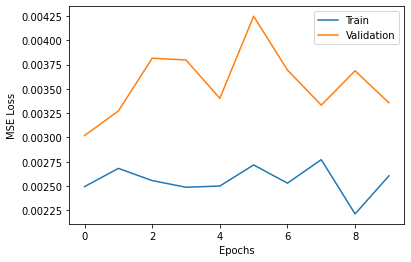

In [20]:
#plot the learning curve
plt.plot(train_scores, label="Train")
plt.plot(valid_scores, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

The MSE loss was low to begin with and did not improve with additional epochs.
The validation MSE is about 0.001 higher than the training MSE

### Evaluate model on Test Data

We shall evaluate our model on the entire test dataset, and obtain the Absolute Error,which is the difference between the real test proportion of 7s and the model prediction.

Then , we will simulate a real world application of the model: 
We will evaluate our model on bags randomly sampled (with replacement) from the test set.
We will plot a distribution of the errors. 

In [31]:

def test(model,bag, bag_label):
    '''validates model over one bag'''
    model.eval()
    with torch.no_grad():
        bag=bag.to(device)
        output = model(bag)

        bag_label= torch.tensor(bag_label,dtype=torch.float32)
        bag_label=bag_label.to(device)
        loss = torch.abs(output- bag_label)
        return loss.item()

def test_epoch(model, dataset, indices):
    ''' loops over the entire validation set and caluclates the MAE for the set
    The test epoch will loop over the entire test dataset. The indices for the test set in the test dataset
    are given as parameter " indices" This function creates bags from the test indices until the test indices are exhausted,
    evaluates the model over each bag, and then creates an aggregate score for the dataset based on the mean of each bag'''
    test_scores=[]
    #produce a bag
    #print("indices:",len(indices))
    bag, bag_label= produce_bag(dataset, 100, indices)
    #print("valid bag1:",bag.shape)
    i=0
    while(bag is not None):
        #print("valid bag:",bag.shape)
        i+=1
        loss= test(model,bag, bag_label)
        test_scores.append(loss)
        #produce a bag
        bag, bag_label= produce_bag(dataset, 100, indices)
    #print the loss
    print("Test score MAE: {}".format(np.mean(test_scores)))
    return np.mean(test_scores)

#validate_epoch(bagged_model, train_valid_data, v, 0,10)




test_indices= list(range(len(test_data)))
test_MAE= test_epoch(bagged_model, test_data, test_indices)
print(f'Test MAE: {test_MAE}')

Test score MAE: 0.02809181362390518
Test MAE: 0.02809181362390518


The MAE for the test is 0.028. This means that the model can predict the percentage of '7' images in 
the MNIST dataset with an average error of 2.8%

In [32]:
### Predict on Test Bags and get a distribution of Absolute Errors, where error = | Predicted proportion of 7 - real proprotion of 7|

def test(model,bag, bag_label):
    '''validates model over one bag'''
    model.eval()
    with torch.no_grad():
        bag=bag.to(device)
        output = model(bag)

        bag_label= torch.tensor(bag_label,dtype=torch.float32)
        bag_label=bag_label.to(device)
        diff= abs(output.item()- bag_label.item())
        
        return diff
indices=list(range(len(test_data)))*10
np.random.shuffle(indices)
errors=[]
for i in range(0, 100):
    bag, bag_label= produce_bag(test_data, 100,indices ) 
    error=test(bagged_model, bag, bag_label)
    errors.append(error)
    print(f"bag:{i}, error: {error}")

bag:0, error: 0.02843576669692993
bag:1, error: 0.10875430703163147
bag:2, error: 0.014365911483764648
bag:3, error: 0.03390440344810486
bag:4, error: 0.008025050163269043
bag:5, error: 0.025855958461761475
bag:6, error: 0.03828051686286926
bag:7, error: 0.11428171396255493
bag:8, error: 0.06057107448577881
bag:9, error: 0.050809264183044434
bag:10, error: 0.026316702365875244
bag:11, error: 0.005697965621948242
bag:12, error: 0.12508505582809448
bag:13, error: 0.06591832637786865
bag:14, error: 0.020237326622009277
bag:15, error: 0.02943134307861328
bag:16, error: 0.015922367572784424
bag:17, error: 0.014583587646484375
bag:18, error: 0.00030243396759033203
bag:19, error: 0.06567913293838501
bag:20, error: 0.01973193883895874
bag:21, error: 0.02738320827484131
bag:22, error: 0.03801983594894409
bag:23, error: 0.0651332437992096
bag:24, error: 0.044268131256103516
bag:25, error: 0.02399522066116333
bag:26, error: 0.003644108772277832
bag:27, error: 0.06307905912399292
bag:28, error: 0.

## Histogram and Boxplot of Test Errors

(array([12.,  7., 14., 14., 10.,  8.,  7., 10.,  3.,  1.,  5.,  2.,  2.,
         1.,  4.]),
 array([6.73532486e-06, 8.40017001e-03, 1.67936047e-02, 2.51870394e-02,
        3.35804741e-02, 4.19739087e-02, 5.03673434e-02, 5.87607781e-02,
        6.71542128e-02, 7.55476475e-02, 8.39410822e-02, 9.23345168e-02,
        1.00727952e-01, 1.09121386e-01, 1.17514821e-01, 1.25908256e-01]),
 <BarContainer object of 15 artists>)

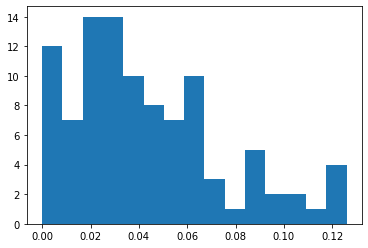

In [33]:
plt.hist(errors, bins=15)

In [45]:
df= pd.DataFrame(errors, columns=["error"])
df[df["error"]>0.1].count()

error    7
dtype: int64

The errors are left skewed. The modal error lies around 0.03 which is similar to the mean.  There are a 7 test bags with errors greater than 0.1 (10%).

{'whiskers': [<matplotlib.lines.Line2D at 0x271b4a64d60>,
 'caps': [<matplotlib.lines.Line2D at 0x271b4a74340>,
 'boxes': [<matplotlib.lines.Line2D at 0x271b4a64a90>],
 'medians': [<matplotlib.lines.Line2D at 0x271b4a748e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x271b4a74bb0>],
 'means': []}

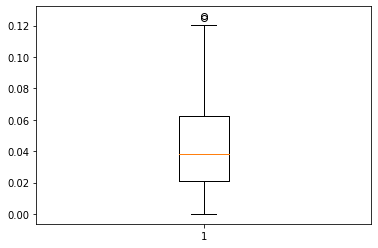

In [46]:
plt.boxplot(errors)

The median error value is close to 0.04, while the lower and upper quartiles are about 0.02 and 0.06 respectively. 